# PS5 - Juan - Clustering Metro Manila Korean Restaurants Using KMeans & DBSCAN

## Requirements


>Geospatial Analytics is a domain heavily used in corporate and business data science. It's used for demand-forecasting, real-estate prediction, population estimation, and optimal route planning..

Using the lessons on DBSCAN, and the other resource notebooks, show the following in this Jupyter Notebook.

Write your answers down as Markdown cells or comments in the code.

1. What are the top 3 most common coffee places? ( 1pt )

2. What is the latitude variance and longitude variance, and explain why these variances are different. ( 3pts )

3. Explain what KMeans intertia is and how different it is from DBSCAN epsilon. ( 4pts )

4. Cluster the locations data with DBSCAN. ( 5pts )

5. Present an analysis of the data following the DBSCAN results. ( 7pts )
 - explain what the clusters mean
 - what does the # of clusters tell us
 - what is this information useful for





-----


Bonus 1 : What is your favorite coffee shop? (1pt)


Bonus 2 : Run everything on your own geospatial dataset, and answer the same questions listed above. (5pts)
Use this: https://developer.foursquare.com/docs/resources/categories
 
----

**Submit this file on Moodle on the submission link I will provide. This is due October 25 12nn.**

# conda install -c conda-forge folium 


In [1]:
import numpy as np
from sklearn.cluster import KMeans
import folium
from folium import plugins
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import foursquare

# Make the graphs a bit prettier, and bigger
# pd.set_option('display.mpl_style', 'default')
plt.style.use('ggplot')

# This is necessary to show lots of columns in pandas 0.12. 
# Not necessary in pandas 0.13.
pd.set_option('display.width', 5000) 
pd.set_option('display.max_columns', 60)

plt.rcParams['figure.figsize'] = (15, 5)

### Scraping Metro Manila Korean Restaurants Listed in FourSquare

In [15]:
places = ["14.73371, 121.06813", "14.73554, 121.01268", "14.72026, 120.96342", \
          "14.6922, 121.06212", "14.69037, 121.01732", "14.68954, 120.97063", \
          "14.65517, 121.05182", "14.65866, 121.01028", "14.64703, 120.9708", \
          "14.6364, 121.07414", "14.64819, 121.1174", "14.62361, 121.03998", \
          "14.61049, 120.9914", "14.60949, 121.10658", "14.60152, 121.05165", \
          "14.56946, 121.09491", "14.5776, 121.05972", "14.5771, 121.02865", \
          "14.5565, 121.02092", "14.55583, 121.02607", "14.55583, 121.02607", \
          "14.55002, 121.06126", "14.55002, 121.04581", "14.5241, 121.02127", \
          "14.47723, 121.02521", "14.44631, 121.00221", "14.40209, 121.02779",
          "14.40209, 121.02779", "14.60974, 121.08002", "14.64969, 121.0747"]
topics = ["samgyupsal", "korean", "romantic baboy", "Korean Restaurant "]

In [16]:
# Construct the client object
client = foursquare.Foursquare(client_id='RZRJAOXWAHARXDWWVCIFEIYZZZFSIYUJJDC2DKQ4HWJ4FTGH', 
                               client_secret='KMKJV3YTKVFJHSGI21CA5N4P3FTWKJTQVVA4R4ETNZSIZDFI', 
                               redirect_uri='http://fondu.com/oauth/authorize')

# Build the authorization url for your app
auth_uri = client.oauth.auth_url()

In [17]:
response = [client.venues.search(params={'query': topic, 
                                         'll': place,
                                        'radius': 2000,
                                        'limit': 30, 
                                        'intent': "browse", 
                                        'categoryId': '4bf58dd8d48988d113941735'})
            for place in places for topic in topics]

In [18]:
len(response)

120

In [19]:
data_list = []
for x in range(len(response)):
    try:
        for i in range(len(response[x]["venues"])):
            poi_id =  response[x]["venues"][i]["id"]
            poi_name =  response[x]["venues"][i]["name"]
            poi_lat =  response[x]["venues"][i]["location"]["lat"]
            poi_lng =  response[x]["venues"][i]["location"]["lng"]
            data_list.append([poi_id, poi_name, poi_lat, poi_lng])
    except KeyError:
        pass

df = pd.DataFrame(data_list, columns=["id", "name", "lat", "lng"])
df = df.drop_duplicates()
df["name"] = df['name'].str.lower()

In [58]:
df.shape

(360, 4)

In [27]:
df.head(5)

,id,name,lat,lng
0,5c95b6ab9cadd9002c1de4e1,samgyupsalamat fairview terraces,14.736643,121.059996
1,4ef863da5c5c68fa0c25f953,mr. kimbob korean healthfood,14.734517,121.059278
2,50c1e9aae4b024b3005bf37b,mr. kimbob (korean health food),14.731630,121.059328
3,5f12e56090a02b480ceb4937,shin korean mart,14.725933,121.057617
7,5b827262a2c00b002ce4f86b,i love samgyupsal,14.734868,120.961270


In [37]:
df.to_csv("data/korean_restaurants.csv") #export to csv

### 1. What are the top 3 most common Korean Restaurant establishments? ( 1pt )


In [29]:
df['name'].value_counts().head(3)

samgyupsalamat            27
romantic baboy            26
premier the samgyupsal     6
Name: name, dtype: int64

### 2. What is the latitude variance and longitude variance, and explain why these variances are different. ( 3pts )

In [25]:
print(f"Latitude variance: {df['lat'].var()}")
print(f"Longitude variance: {df['lng'].var()}")

Latitude variance: 0.004217226156631839
Longitude variance: 0.0009997748372354255


As we can see, the variance in latitude is greater than the variance in longitude for the scraped Metro Manila Korean restaurants. 

This difference might be attributed to the fact that the scraped locations are limited to Metro Manila, so there are more variations latitude wise than longitude wise in terms of location distribution.

### 3. Explain what KMeans intertia is and how different it is from DBSCAN epsilon. ( 4pts )

KMeans intertia is the sum of squared distances of samples to their closest cluster center. Intuitively, it tells how far away the points within a cluster are. Therefore, a small value of inertia is aimed for. The range of inertia’s value starts from zero and goes up. 

DBSCAN Epsilon, on the other hand, is the radius of the circle to be created around each data point to check the density. 

Inertia is used to assess the quality of the clustering result from KMeans while DBScan Epsilon is a hyperparameter that we specify that influences how the DBSCAN algorithm clusters the data.

### 4. Cluster the locations data with DBSCAN. ( 5pts )

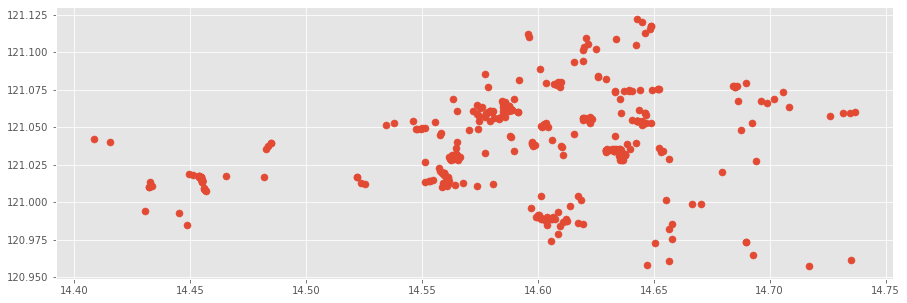

In [31]:
# Before clustering the data using DBScan, let's check out how K-means clusters the group.
X = np.array(df[["lat", "lng"]].values.tolist())
plt.scatter(X[:, 0], X[:, 1], s=50)

In [32]:
sum_of_squared_distances = []
K = range(1,30)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    sum_of_squared_distances.append(km.inertia_)

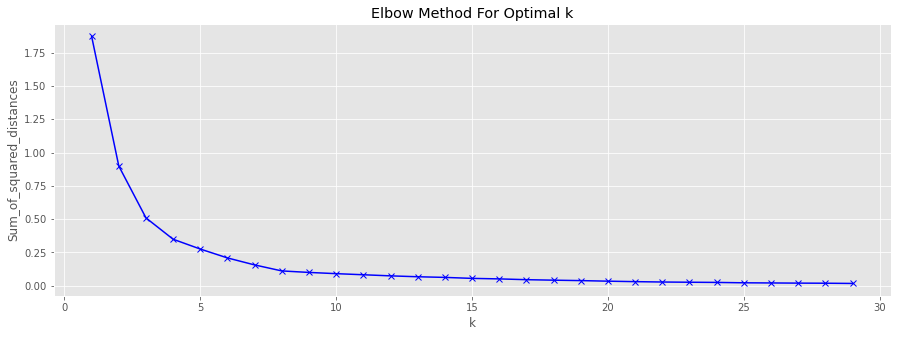

In [33]:
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

From the plot above, I think k=4 is a good elbow breaking point.

In [38]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

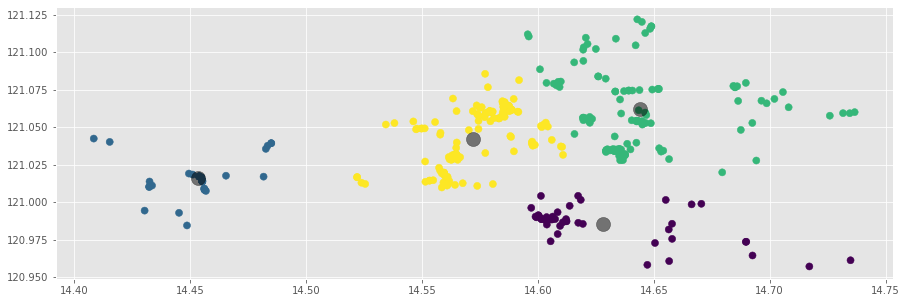

In [39]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

In [40]:
df_kmeans = df.copy()
df_kmeans["cluster"] = y_kmeans

In [41]:
df_kmeans.head()

,id,name,lat,lng,cluster
0,5c95b6ab9cadd9002c1de4e1,samgyupsalamat fairview terraces,14.736643,121.059996,2
1,4ef863da5c5c68fa0c25f953,mr. kimbob korean healthfood,14.734517,121.059278,2
2,50c1e9aae4b024b3005bf37b,mr. kimbob (korean health food),14.731630,121.059328,2
3,5f12e56090a02b480ceb4937,shin korean mart,14.725933,121.057617,2
7,5b827262a2c00b002ce4f86b,i love samgyupsal,14.734868,120.961270,0


In [42]:
palette = sns.color_palette("pastel", 4).as_hex()

In [43]:
color_getter = lambda x: palette[int(x)]
df_kmeans["color"] = df_kmeans["cluster"].map(color_getter)
df_kmeans.head()

,id,name,lat,lng,cluster,color
0,5c95b6ab9cadd9002c1de4e1,samgyupsalamat fairview terraces,14.736643,121.059996,2,#8de5a1
1,4ef863da5c5c68fa0c25f953,mr. kimbob korean healthfood,14.734517,121.059278,2,#8de5a1
2,50c1e9aae4b024b3005bf37b,mr. kimbob (korean health food),14.731630,121.059328,2,#8de5a1
3,5f12e56090a02b480ceb4937,shin korean mart,14.725933,121.057617,2,#8de5a1
7,5b827262a2c00b002ce4f86b,i love samgyupsal,14.734868,120.961270,0,#a1c9f4


In [44]:
basemap = folium.Map(location=[14.5562297,121.0204097], tiles="cartodbdark_matter", zoom_start=15)

for index, row in df_kmeans.iterrows():
    folium.CircleMarker([row["lat"], row["lng"]], radius=5,
        fill=True,
        color =row["color"],
        popup = folium.Popup(row["name"], parse_html=True),
        fill_color=row["color"]).add_to(basemap)
    

basemap

From the number of clusters we got from the elbow plot, we can see that the restaurant were clustered based on North West, North East, Middle and South of Metro Manila. Interesting! A larger specified cluster number might lead us to more location / city specific groupings.

On to DBSCAN!

### Optimizing Epsilon Value
Reference: https://iopscience.iop.org/article/10.1088/1755-1315/31/1/012012/pdf

In [96]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=4)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)

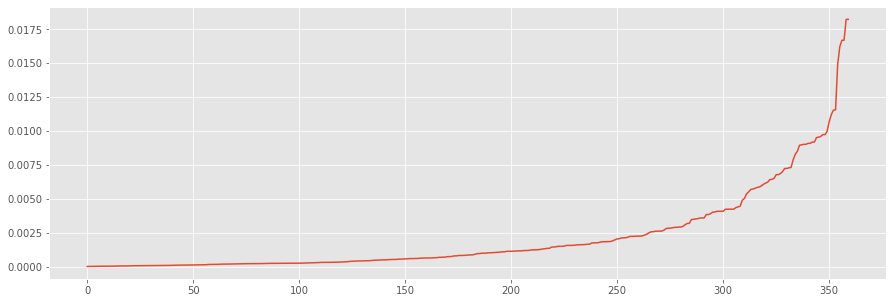

In [97]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)


In [139]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.006125, min_samples=3).fit(X)  #0.005, 0.00125, 0.0075 (22 clusters), 0.06()
y_dbscan = dbscan.labels_

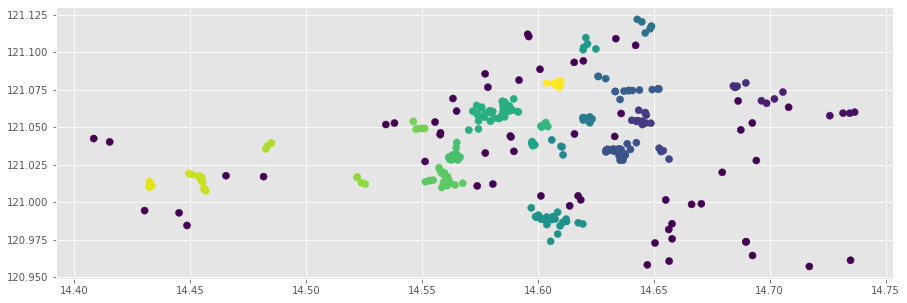

In [140]:
plt.scatter(X[:, 0], X[:, 1], c=y_dbscan, s=50, cmap='viridis')

In [141]:
df_dbscan = df.copy()
df_dbscan["dbscan_cluster"] = y_dbscan
palette = sns.color_palette("pastel", len(y_dbscan)).as_hex()
color_getter = lambda x: palette[int(x)]
df_dbscan["db_color"] = df_dbscan["dbscan_cluster"].map(color_getter)
df_dbscan.head()

,id,name,lat,lng,dbscan_cluster,db_color
0,5c95b6ab9cadd9002c1de4e1,samgyupsalamat fairview terraces,14.736643,121.059996,0,#a1c9f4
1,4ef863da5c5c68fa0c25f953,mr. kimbob korean healthfood,14.734517,121.059278,0,#a1c9f4
2,50c1e9aae4b024b3005bf37b,mr. kimbob (korean health food),14.731630,121.059328,0,#a1c9f4
3,5f12e56090a02b480ceb4937,shin korean mart,14.725933,121.057617,0,#a1c9f4
7,5b827262a2c00b002ce4f86b,i love samgyupsal,14.734868,120.961270,-1,#b9f2f0


In [142]:
df_dbscan.shape

(360, 6)

In [143]:
df_dbscan = df_dbscan[df_dbscan["dbscan_cluster"] > -1]

In [144]:
df_dbscan.shape

(302, 6)

In [145]:
basemap = folium.Map(location=[14.5562297,121.0204097], tiles="cartodbdark_matter", zoom_start=15) #

for index, row in df_dbscan.iterrows():
    folium.CircleMarker([row["lat"], row["lng"]], radius=5,
    fill=True,
    color =row["db_color"],
                        popup = folium.Popup(row["name"], parse_html=True),
    fill_color=row["db_color"]).add_to(basemap)
    

basemap

### 5. Present an analysis of the data following the DBSCAN results. ( 7pts )
 - explain what the clusters mean
 - what does the # of clusters tell us
 - what is this information useful for

In [146]:
df_dbscan['dbscan_cluster'].value_counts().count() # no. of clusters

24

- The clusters are what I'd like to brand as "Samgyup" hotspots (haha jk). More seriously, they are Metro Manila Korean restaurant (mostly samgyupsal places) hotspots i.e. these are Korean restaurants that are geographically close to each other.

- The number of clusters tells us that from the limited data we scraped from Foursquare, the DBSCAN algorithm was able to cluster this set of restaurants into 24 "hotspots" -- quite a large number and a testament to the Filipino's growing fascination with Korean cuisine

- This information is useful as it could potentially be used with, for example, a mapping software that could help us identify city boundaries. Now per city, we could then have a list of clusters or "hotspots" which can help hungry Filipinos craving for Korean cuisine to know which spots to go in their respective cities that has the widest selection of choices. In terms of interested business owners, it can help them identify which areas in Metro Manila have limited Korean restaurants, opening up new opportunities for them to scope out market saturation.